In [1]:

from sklearn.decomposition import TruncatedSVD, KernelPCA

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

In [2]:

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import mahalanobis
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from collections import defaultdict



import pandas as pd
from sklearn.model_selection import train_test_split

def load_data():

    """
    datasets={
        "bruteforce":"dataset3/d3_bruteforce_payload_clean.csv",   
        "capture_1w":"dataset3/d3_capture_1w_payload_clean.csv",
        "capture_flood":"dataset3/d3_capture_flood_payload_clean.csv",
        "malariaDoS":"dataset3/d3_capture_malariaDoS_payload_clean.csv",
        "malformed":"dataset3/d3_malformed_payload_clean.csv",
        "slowite":"dataset3/d3_slowite_payload_clean.csv",  
    }
    class_labels = {
        "bruteforce": 0,
        "capture_1w": 1,
        "capture_flood": 2,
        "malariaDoS": 3,
        "malformed": 4  ,
        "slowite":5
    }
    """

    datasets={
        "normal":"dataset1/normal_test.csv",   
        
        "dos_connectflood":"dataset1/dos_connectflood_test.csv",
        "dos_publish_flood":"dataset1/dos_publish_flood_test.csv",
        
        "malformed_test":"dataset1/malformed_test.csv"
        
    }
    class_labels = {
        "normal": 0,
        "ddos_connectflood": 1,
        "dos_connectflood": 2,
        "dos_publish_flood": 3,
        "malformed_test":4,
        "ddos_publish_flood": 3,
    }
    

    all_data = []
    payload_class_count = {}

    # First Pass: Count payload occurrences across classes
    for attack, file in datasets.items():
        df = pd.read_csv(file, encoding='latin1')
        print(len(df))

        if "Payload (Hex)" in df.columns:
            for payload in df["Payload (Hex)"].dropna().unique():
                payload_class_count[payload] = payload_class_count.get(payload, 0) + 1

    print("jsbdj")
    for attack, file in datasets.items():
        df = pd.read_csv(file, encoding='latin1')
        df["Class"] = class_labels[attack]

        if "Payload (Hex)" in df.columns:
            df = df[df["Payload (Hex)"].notna()]
            df = df[df["Payload (Hex)"].apply(lambda x: payload_class_count.get(x, 0) == 1)]
            df.to_csv(f"filtered_{attack}.csv", index=False)
            print(len(df))
        

        if len(df) > 2000:
            df = df.sample(n=2000, random_state=42)  # Sampling for balance

        all_data.append(df)

    full_df = pd.concat(all_data, ignore_index=True)

    print("Class Distribution After Filtering:\n", full_df["Class"].value_counts())

    train_df, test_df = train_test_split(full_df, test_size=0.2, random_state=42, stratify=full_df["Class"])
    

    train_df["Payload Text"] = train_df["Payload (Hex)"].astype(str)
    test_df["Payload Text"] = test_df["Payload (Hex)"].astype(str)
    train_new_df, valid_df = train_test_split(train_df, test_size=0.7, random_state=42, stratify=train_df["Class"])
    # unknown_df = pd.read_csv("dataset3/d3_bruteforce_payload_clean.csv", encoding='latin1')
    # print(f"malformed shape: {unknown_df.shape}")
    # unknown_df["Class"] = 5
    # unknown_df = unknown_df.sample(n=min(len(unknown_df), 350), random_state=42)
    # unknown_df["Payload Text"] = unknown_df["Payload (Hex)"].astype(str)
    # test_df = pd.concat([test_df, unknown_df], ignore_index=True)
    return train_new_df,valid_df, test_df




    




tfidf_vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(3, 5), max_features=2500)
svd = TruncatedSVD(n_components=50, random_state=42)
scaler = StandardScaler()
def extract_features(df, fit=True):
    if fit:
        print("Fitting global TF-IDF and SVD...")
        X_tfidf = tfidf_vectorizer.fit_transform(df["Payload Text"])
        X_reduced = svd.fit_transform(X_tfidf)
        X_scaled = scaler.fit_transform(X_reduced)
    else:
        print("Transforming using global TF-IDF and SVD...")
        X_tfidf = tfidf_vectorizer.transform(df["Payload Text"])
        X_reduced = svd.transform(X_tfidf)
        X_scaled = scaler.transform(X_reduced)

    return X_reduced, df["Class"]




def balance_data(X_train, y_train):
    print("Applying SMOTE...")
    smote = SMOTE(sampling_strategy='auto', random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    print(f"SMOTE Applied: Resampled Training Size = {X_train_resampled.shape}")

    return X_train_resampled, y_train_resampled




In [136]:
test_df.tail(500)

,Source IP,Destination IP,Payload (Raw),Payload (Hex),Class,Unnamed: 0,Payload Text
6594,192.168.137.48,192.168.137.250,b'0\x15\x00\x0fspirometer_datatest',3015000f737069726f6d657465725f6461746174657374,4,12446.0,3015000f737069726f6d657465725f6461746174657374
26,10.0.0.7,10.0.0.254,b'0\x13\x00\x0fheart_rate_data680\x15\x00\x11o...,3013000f68656172745f726174655f6461746136383015...,0,NaN,3013000f68656172745f726174655f6461746136383015...
5082,192.168.137.180,192.168.137.250,b'\x10\x1c\x00\x04MQTT\x04\x02\x00\x1e\x00\x10...,101c00044d5154540402001e00106d7174742d62656e63...,3,NaN,101c00044d5154540402001e00106d7174742d62656e63...
7120,192.168.137.250,192.168.137.196,b'0\x11\x00\rpulse_ox_data850\x10\x00\x0cairfl...,3011000d70756c73655f6f785f6461746138353010000c...,4,3097.0,3011000d70756c73655f6f785f6461746138353010000c...
418,10.0.0.7,10.0.0.254,b'0\x14\x00\x0fheart_rate_data1800\x15\x00\x11...,3014000f68656172745f726174655f6461746131383030...,0,NaN,3014000f68656172745f726174655f6461746131383030...
...,...,...,...,...,...,...,...
8496,192.168.137.48,192.168.137.250,b'\x10\x12\x00\x04MQTT\x04\x02\x00<\x00\x06$to...,101200044d5154540402003c000624746f706963,4,10521.0,101200044d5154540402003c000624746f706963
1631,10.0.0.7,10.0.0.254,b'0\x14\x00\x0fheart_rate_data1580\x15\x00\x11...,3014000f68656172745f726174655f6461746131353830...,0,NaN,3014000f68656172745f726174655f6461746131353830...
6803,192.168.137.48,192.168.137.250,b'0\x19\x00\x0bweight_datatesttesttest',3019000b7765696768745f646174617465737474657374...,4,968.0,3019000b7765696768745f646174617465737474657374...
2676,192.168.137.48,192.168.137.250,b'\x10\x0f\x00\x04MQTT\x04\x02\x0e\x10\x00\x03...,100f00044d51545404020e100003373837,2,190846.0,100f00044d51545404020e100003373837


In [3]:
train_df,valid_df,test_df = load_data()

119008
232261
460660
12565
jsbdj
26774
223912


KeyboardInterrupt: 

In [ ]:
X_train, y_train = extract_features(train_df, fit=True)
X_valid, y_valid = extract_features(valid_df, fit=False)
X_test, y_test = extract_features(test_df, fit=False)

In [ ]:
print(X_test[100])
print(y_test[100])
print(X_test[0])
print(y_test[0])

In [154]:
import networkx as nx
from scipy.spatial.distance import mahalanobis
from sklearn.preprocessing import LabelEncoder
class MahalanobisLayer:
    def __init__(self, alpha=1e-5):
        self.centroids = None
        self.covariance_inv = None
        self.class_labels = None
        self.alpha = alpha

    def fit(self, X_train, y_train):
        self.class_labels = np.unique(y_train)
        self.centroids = []
        self.covariance_inv = []
        for label in self.class_labels:
            class_data = X_train[y_train == label]
            centroid = np.mean(class_data, axis=0)
            cov = np.cov(class_data.T) + np.eye(class_data.shape[1]) * self.alpha
            self.centroids.append(centroid)
            self.covariance_inv.append(np.linalg.inv(cov))
        return self

    def compute_distances(self, X):
        n_classes = len(self.centroids)
        distances = []
        for x in X:
            dist = np.zeros(n_classes)
            for j in range(n_classes):
                dist[j] = mahalanobis(x, self.centroids[j], self.covariance_inv[j])
            dist = np.where(np.isnan(dist), float('inf'), dist)
            distances.append(dist)
        return np.array(distances)


class GridGraphClassifier:
    def __init__(self, n_bins=20):
        self.n_bins = n_bins
        self.graph = None
        self.cell_labels = {}
        self.class_labels = None  # Store class labels
        self.bin_edges_list = None  # To store bin edges for each dimension

    def _compute_bin_edges(self, distances):
        """Compute and store bin edges for each dimension using the training data."""
        n_classes = distances.shape[1]
        self.bin_edges_list = []
        for i in range(n_classes):
            percentiles = np.linspace(0, 100, self.n_bins + 1)
            # Compute bin edges from the training distances for each feature/dimension.
            bin_edges = np.percentile(distances[:, i], percentiles)
            self.bin_edges_list.append(bin_edges)

    def _discretize_features(self, distances):
        """Discretize features using precomputed bin edges (if available), or compute them."""
        n_classes = distances.shape[1]
        cell_indices = np.zeros_like(distances, dtype=int)
        if self.bin_edges_list is not None:
            for i in range(n_classes):
                bin_edges = self.bin_edges_list[i]
                cell_indices[:, i] = np.digitize(distances[:, i], bin_edges, right=False) - 1
                cell_indices[:, i] = np.clip(cell_indices[:, i], 0, self.n_bins - 1)
        else:
            # If not, compute bin edges on the fly (this case should occur during training).
            for i in range(n_classes):
                percentiles = np.linspace(0, 100, self.n_bins + 1)
                bin_edges = np.percentile(distances[:, i], percentiles)
                cell_indices[:, i] = np.digitize(distances[:, i], bin_edges, right=False) - 1
                cell_indices[:, i] = np.clip(cell_indices[:, i], 0, self.n_bins - 1)
        return cell_indices

    def _build_grid_graph(self, cell_indices):
        self.graph = nx.Graph()
        unique_cells = np.unique(cell_indices, axis=0)
        for cell in unique_cells:
            self.graph.add_node(tuple(cell))
        for i, cell1 in enumerate(unique_cells):
            for cell2 in unique_cells[i+1:]:
                diff = np.abs(cell1 - cell2)
                if np.sum(diff) == 1 and np.max(diff) == 1:
                    self.graph.add_edge(tuple(cell1), tuple(cell2))

    def _assign_initial_labels(self, cell_indices, y_train):
        for idx, cell in enumerate(cell_indices):
            cell_tuple = tuple(cell)
            if cell_tuple not in self.cell_labels:
                self.cell_labels[cell_tuple] = []
            self.cell_labels[cell_tuple].append(y_train[idx])
        for cell in self.cell_labels:
            labels = np.array(self.cell_labels[cell])
            unique, counts = np.unique(labels, return_counts=True)
            majority_label = unique[np.argmax(counts)]
            self.cell_labels[cell] = majority_label
#fork 1

    def fit(self, X_train, y_train, mahalanobis_layer):
        X_train = np.asarray(X_train)
        y_train = np.asarray(y_train)
        self.class_labels = mahalanobis_layer.class_labels
        distances = mahalanobis_layer.compute_distances(X_train)
        # Compute and store bin edges from training data
        self._compute_bin_edges(distances)
        cell_indices = self._discretize_features(distances)
        self._build_grid_graph(cell_indices)
        self._assign_initial_labels(cell_indices, y_train)
        return self


    def predict(self, X, mahalanobis_layer):
        X = np.asarray(X)
        distances = mahalanobis_layer.compute_distances(X)
        cell_indices = self._discretize_features(distances)

        predictions = []
        for cell in cell_indices:
            cell_tuple = tuple(cell)
            if cell_tuple in self.cell_labels and self.cell_labels[cell_tuple] is not None:
                predictions.append(self.cell_labels[cell_tuple])
            else:
                nearest_label = self._check_one_step_neighbors(cell_tuple)
                predictions.append(nearest_label)
        return np.array(predictions)

    def _check_one_step_neighbors(self, cell):
        cell = np.array(cell)
        for dim in range(len(cell)):
            for delta in [-1, 1]:
                neighbor = cell.copy()
                neighbor[dim] += delta
                neighbor_tuple = tuple(neighbor)
                if neighbor_tuple in self.cell_labels and self.cell_labels[neighbor_tuple] is not None:
                    return self.cell_labels[neighbor_tuple]
        return 4 # fallback class

In [260]:
mahalanobis_layer = MahalanobisLayer(alpha=0)
mahalanobis_layer.fit(X_train, y_train)

In [26]:
print(grid_classifier.graph.number_of_nodes())

392


In [261]:
grid_classifier = GridGraphClassifier(n_bins=12)
grid_classifier.fit(X_valid, y_valid, mahalanobis_layer)

C:\Users\vasir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\scipy\spatial\distance.py:1035: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(m)
C:\Users\vasir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


0.9910389246709606

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       900
           1       1.00      1.00      1.00       900
           2       1.00      1.00      1.00       900
           3       0.99      0.98      0.98       871
           4       0.00      0.00      0.00         0

    accuracy                           0.99      3571
   macro avg       0.79      0.79      0.79      3571
weighted avg       0.99      0.99      0.99      3571



C:\Users\vasir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vasir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vasir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: Unde

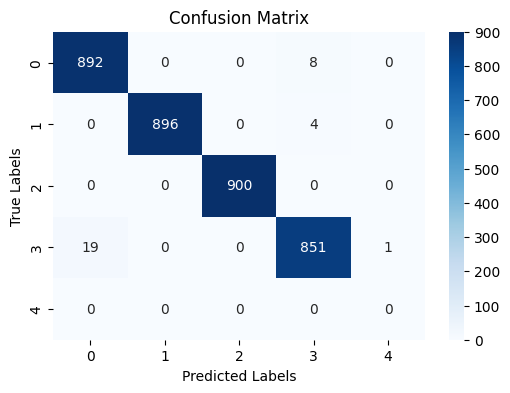

In [262]:
results = grid_classifier.predict(X_test, mahalanobis_layer)
print(accuracy_score(y_test,results))
print("\nClassification Report:\n", classification_report(y_test, results))
cm = confusion_matrix(y_test, results)

# Confusion Matrix Plot
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

0.8819444444444444

Classification Report:
               precision    recall  f1-score   support

           0       0.77      1.00      0.87       900
           1       0.86      1.00      0.92       900
           2       1.00      1.00      1.00       900
           3       0.99      0.53      0.69       900

    accuracy                           0.88      3600
   macro avg       0.90      0.88      0.87      3600
weighted avg       0.90      0.88      0.87      3600



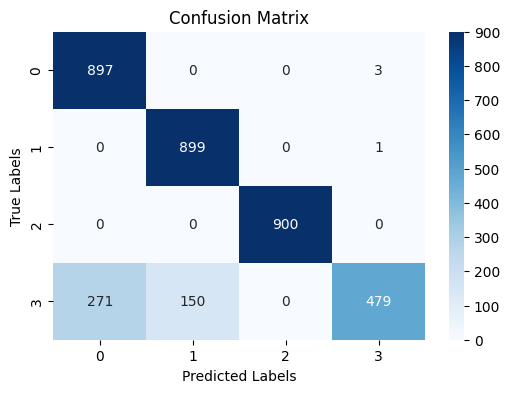

In [210]:
results = grid_classifier.predict(X_test, mahalanobis_layer)
print(accuracy_score(y_test,results))
print("\nClassification Report:\n", classification_report(y_test, results))
cm = confusion_matrix(y_test, results)

# Confusion Matrix Plot
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [45]:
from sklearn.decomposition import TruncatedSVD, KernelPCA

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm


import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import mahalanobis
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from collections import defaultdict
import os


import pandas as pd
from sklearn.model_selection import train_test_split

def load_data():

    # datasets={
    #     "bruteforce":"dataset3/d3_capture_flood_payload_clean.csv",   
    #     "capture_1w":"dataset3/d3_capture_1w_payload_clean.csv",
    #     "capture_flood":"dataset3/d3_capture_malariaDoS_payload_clean.csv",
    #     "malariaDoS":"dataset3/d3_malformed_payload_clean.csv",
    #     "malformed":"dataset3/d3_slowite_payload_clean.csv",
    #     #"slowite":"dataset3/d3_slowite_payload_clean.csv",
        
    # }
    # class_labels = {
    #     "bruteforce": 0,
    #     "capture_1w": 1,
    #     "capture_flood": 2,
    #     "malariaDoS": 3,
    #     "malformed": 4  ,
    #     "slowite":5
    # }

    datasets={
        "normal":"dataset1/filtered_normal.csv",
        "dos_connectflood":"dataset1/filtered_dos_connectflood.csv",
        
        "malformed_test":"dataset1/filtered_malformed_test.csv",
        "dos_publish_flood":"dataset1/filtered_dos_publish_flood.csv"
    }
    class_labels = {
        "normal": 0,
        "dos_connectflood": 1,
        "malformed_test":2,
        "dos_publish_flood":3
    }
    

    all_data = []
    payload_class_count = {}

    for attack, file in datasets.items():
        df = pd.read_csv(file, encoding='latin1')
        df["Class"] = class_labels[attack]

        if "Payload (Hex)" in df.columns:
            df = df[df["Payload (Hex)"].notna()]
            #df = df[df["Payload (Hex)"].apply(lambda x: payload_class_count.get(x, 0) == 1)]  # Ensure key exists
            print(len(df))
        

        if len(df) > 4500:
            df = df.sample(n=4500, random_state=42)  # Sampling for balance

        all_data.append(df)

    full_df = pd.concat(all_data, ignore_index=True)

    print("Class Distribution After Filtering:\n", full_df["Class"].value_counts())

    train_df, test_df = train_test_split(full_df, test_size=0.2, random_state=42, stratify=full_df["Class"])
    

    train_df["Payload Text"] = train_df["Payload (Hex)"].astype(str)
    test_df["Payload Text"] = test_df["Payload (Hex)"].astype(str)
    train_new_df, valid_df = train_test_split(train_df, test_size=0.7, random_state=42, stratify=train_df["Class"])
    # unknown_df = pd.read_csv("dataset1/filtered_dos_publish_flood.csv", encoding='latin1')
    # print(f"malformed shape: {unknown_df.shape}")
    # unknown_df["Class"] = 3
    # unknown_df = unknown_df.sample(n=min(len(unknown_df), 900), random_state=42)
    # unknown_df["Payload Text"] = unknown_df["Payload (Hex)"].astype(str)
    # test_df = pd.concat([test_df, unknown_df], ignore_index=True)
    return train_new_df,valid_df, test_df




    




tfidf_vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(3, 5), max_features=2500)
svd = TruncatedSVD(n_components=50, random_state=42)
scaler = StandardScaler()
def extract_features(df, fit=True):
    if fit:
        print("Fitting global TF-IDF and SVD...")
        X_tfidf = tfidf_vectorizer.fit_transform(df["Payload Text"])
        X_reduced = svd.fit_transform(X_tfidf)
        X_scaled = scaler.fit_transform(X_reduced)
    else:
        print("Transforming using global TF-IDF and SVD...")
        X_tfidf = tfidf_vectorizer.transform(df["Payload Text"])
        X_reduced = svd.transform(X_tfidf)
        X_scaled = scaler.transform(X_reduced)

    return X_reduced, df["Class"]




def balance_data(X_train, y_train):
    print("Applying SMOTE...")
    smote = SMOTE(sampling_strategy='auto', random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    print(f"SMOTE Applied: Resampled Training Size = {X_train_resampled.shape}")

    return X_train_resampled, y_train_resampled

import networkx as nx
from scipy.spatial.distance import mahalanobis
from sklearn.preprocessing import LabelEncoder
class MahalanobisLayer:
    def __init__(self, alpha=1e-5):
        self.centroids = None
        self.covariance_inv = None
        self.class_labels = None
        self.alpha = alpha

    def fit(self, X_train, y_train):
        self.class_labels = np.unique(y_train)
        self.centroids = []
        self.covariance_inv = []
        for label in self.class_labels:
            class_data = X_train[y_train == label]
            centroid = np.mean(class_data, axis=0)
            cov = np.cov(class_data.T) + np.eye(class_data.shape[1]) * self.alpha
            self.centroids.append(centroid)
            self.covariance_inv.append(np.linalg.inv(cov))
        return self

    def compute_distances(self, X):
        n_classes = len(self.centroids)
        distances = []
        for x in X:
            dist = np.zeros(n_classes)
            for j in range(n_classes):
                dist[j] = mahalanobis(x, self.centroids[j], self.covariance_inv[j])
            dist = np.where(np.isnan(dist), float('inf'), dist)
            distances.append(dist)
        return np.array(distances)


class GridGraphClassifier:
    def __init__(self, n_bins=20):
        self.n_bins = n_bins
        self.graph = None
        self.cell_labels = {}
        self.class_labels = None  # Store class labels
        self.bin_edges_list = None  # To store bin edges for each dimension

    def _compute_bin_edges(self, distances):
        """Compute and store bin edges for each dimension using the training data."""
        n_classes = distances.shape[1]
        self.bin_edges_list = []
        for i in range(n_classes):
            percentiles = np.linspace(0, 100, self.n_bins + 1)
            # Compute bin edges from the training distances for each feature/dimension.
            bin_edges = np.percentile(distances[:, i], percentiles)
            self.bin_edges_list.append(bin_edges)

    def _discretize_features(self, distances):
        """Discretize features using precomputed bin edges (if available), or compute them."""
        n_classes = distances.shape[1]
        cell_indices = np.zeros_like(distances, dtype=int)
        if self.bin_edges_list is not None:
            for i in range(n_classes):
                bin_edges = self.bin_edges_list[i]
                cell_indices[:, i] = np.digitize(distances[:, i], bin_edges, right=False) - 1
                cell_indices[:, i] = np.clip(cell_indices[:, i], 0, self.n_bins - 1)
        else:
            # If not, compute bin edges on the fly (this case should occur during training).
            for i in range(n_classes):
                percentiles = np.linspace(0, 100, self.n_bins + 1)
                bin_edges = np.percentile(distances[:, i], percentiles)
                cell_indices[:, i] = np.digitize(distances[:, i], bin_edges, right=False) - 1
                cell_indices[:, i] = np.clip(cell_indices[:, i], 0, self.n_bins - 1)
        return cell_indices

    def _build_grid_graph(self, cell_indices):
        self.graph = nx.Graph()
        unique_cells = np.unique(cell_indices, axis=0)
        for cell in unique_cells:
            self.graph.add_node(tuple(cell))
        for i, cell1 in enumerate(unique_cells):
            for cell2 in unique_cells[i+1:]:
                diff = np.abs(cell1 - cell2)
                if np.sum(diff) == 1 and np.max(diff) == 1:
                    self.graph.add_edge(tuple(cell1), tuple(cell2))

    def _assign_initial_labels(self, cell_indices, y_train):
        for idx, cell in enumerate(cell_indices):
            cell_tuple = tuple(cell)
            if cell_tuple not in self.cell_labels:
                self.cell_labels[cell_tuple] = []
            self.cell_labels[cell_tuple].append(y_train[idx])
        for cell in self.cell_labels:
            labels = np.array(self.cell_labels[cell])
            unique, counts = np.unique(labels, return_counts=True)
            majority_label = unique[np.argmax(counts)]
            self.cell_labels[cell] = majority_label
#fork 1

    def fit(self, X_train, y_train, mahalanobis_layer):
        X_train = np.asarray(X_train)
        y_train = np.asarray(y_train)
        self.class_labels = mahalanobis_layer.class_labels
        distances = mahalanobis_layer.compute_distances(X_train)
        # Compute and store bin edges from training data
        self._compute_bin_edges(distances)
        cell_indices = self._discretize_features(distances)
        self._build_grid_graph(cell_indices)
        self._assign_initial_labels(cell_indices, y_train)
        return self


    def predict(self, X, mahalanobis_layer):
        X = np.asarray(X)
        distances = mahalanobis_layer.compute_distances(X)
        cell_indices = self._discretize_features(distances)

        predictions = []
        for cell in cell_indices:
            cell_tuple = tuple(cell)
            if cell_tuple in self.cell_labels and self.cell_labels[cell_tuple] is not None:
                predictions.append(self.cell_labels[cell_tuple])
            else:
                nearest_label = self._check_one_step_neighbors(cell_tuple)
                predictions.append(nearest_label)
        return np.array(predictions)

    def _check_one_step_neighbors(self, cell):
        cell = np.array(cell)
        for dim in range(len(cell)):
            for delta in [-1, 1]:
                neighbor = cell.copy()
                neighbor[dim] += delta
                neighbor_tuple = tuple(neighbor)
                if neighbor_tuple in self.cell_labels and self.cell_labels[neighbor_tuple] is not None:
                    return self.cell_labels[neighbor_tuple]
        return 4 # fallback class

    def _check_nearest_labeled_cell(self, cell):
        cell = np.array(cell)
        min_distance = float('inf')
        nearest_label = 6  # default if no label is found

        for labeled_cell, label in self.cell_labels.items():
            if label is not None:
                labeled_cell_np = np.array(labeled_cell)
                distance = np.linalg.norm(cell - labeled_cell_np)
                if distance < min_distance:
                    min_distance = distance
                    nearest_label = label

        return nearest_label

In [25]:

XX = np.concatenate((X_train,X_valid), axis=0)
YY = np.concatenate((y_train,y_valid), axis=0)



In [26]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import tree
import matplotlib.pyplot as plt


# Create and train decision tree
clf = DecisionTreeClassifier(criterion='gini', max_depth=9, random_state=42)
clf.fit(XX,YY)

# Predict and evaluate
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
cm=confusion_matrix(y_test, y_pred)
print(cm)


Accuracy: 0.7437692523102772
[[898   0   2   0]
 [  0 896   4   0]
 [  8   1 862   0]
 [  0   0 900   0]]


In [27]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt



# Create and train the Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(XX,YY)

# Make predictions
y_pred = rf.predict(X_test)

# Evaluate accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Display confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

Accuracy: 0.7454494539344722
[[897   0   3   0]
 [  0 896   4   0]
 [  2   0 869   0]
 [  0   0 900   0]]


In [28]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt



base_estimator = DecisionTreeClassifier(max_depth=10)
adb = AdaBoostClassifier(estimator=base_estimator, n_estimators=100, learning_rate=1.0, random_state=42)

# Train the model
adb.fit(XX, YY)

# Predict
y_pred = adb.predict(X_test)

# Evaluate accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

C:\Users\vasir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy: 0.7457294875385047
[[898   0   2   0]
 [  0 896   4   0]
 [  2   0 869   0]
 [  0   0 900   0]]


In [29]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score



knn = KNeighborsClassifier(n_neighbors=5)

# Train the model
knn.fit(XX,YY)

# Predict on test data
y_pred = knn.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
cm=confusion_matrix(y_test, y_pred)
print(cm)

Accuracy: 0.7423690842901148
[[894   0   6   0]
 [  0 896   4   0]
 [ 10   0 861   0]
 [  0   0 900   0]]


In [38]:
train_df,valid_df,test_df = load_data()
X_train, y_train = extract_features(train_df, fit=True)
X_valid, y_valid = extract_features(valid_df, fit=False)
X_test, y_test = extract_features(test_df, fit=False)

26774
223912
4353
459566
Class Distribution After Filtering:
 Class
0    4500
1    4500
3    4500
2    4353
Name: count, dtype: int64
Fitting global TF-IDF and SVD...
Transforming using global TF-IDF and SVD...
Transforming using global TF-IDF and SVD...


In [42]:
mahalanobis_layer = MahalanobisLayer(alpha=0)
mahalanobis_layer.fit(X_train, y_train)

In [43]:
grid_classifier = GridGraphClassifier(n_bins=15)
grid_classifier.fit(X_valid, y_valid, mahalanobis_layer)

C:\Users\vasir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\scipy\spatial\distance.py:1035: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(m)
C:\Users\vasir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


0.991879025483058

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       900
           1       1.00      1.00      1.00       900
           2       0.98      0.99      0.98       871
           3       1.00      1.00      1.00       900

    accuracy                           0.99      3571
   macro avg       0.99      0.99      0.99      3571
weighted avg       0.99      0.99      0.99      3571



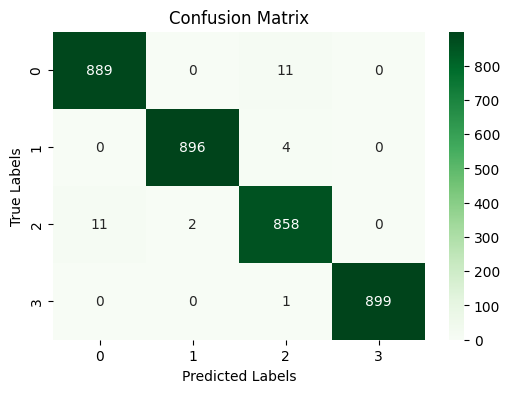

In [44]:
results = grid_classifier.predict(X_test, mahalanobis_layer)
print(accuracy_score(y_test,results))
print("\nClassification Report:\n", classification_report(y_test, results))
cm = confusion_matrix(y_test, results)

# Confusion Matrix Plot
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

0.9882385886306356

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       900
           1       1.00      1.00      1.00       900
           2       1.00      1.00      1.00       900
           3       0.99      0.97      0.98       871
           4       0.00      0.00      0.00         0

    accuracy                           0.99      3571
   macro avg       0.79      0.79      0.79      3571
weighted avg       0.99      0.99      0.99      3571



C:\Users\vasir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vasir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vasir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: Unde

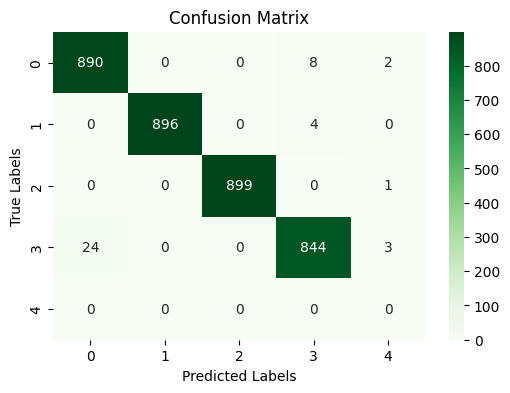

[0.9129095491458975, 0.9568748249789975, 0.9717166059927191, 0.9840380845701484, 0.9873984878185382, 0.9862783534024083, 0.9879585550266032, 0.9879585550266032, 0.9893587230467656, 0.9879585550266032, 0.9887986558387006, 0.9879585550266032, 0.9921590590870905, 0.9865583870064407, 0.9873984878185382, 0.9899187902548305, 0.990198823858863, 0.9882385886306356]


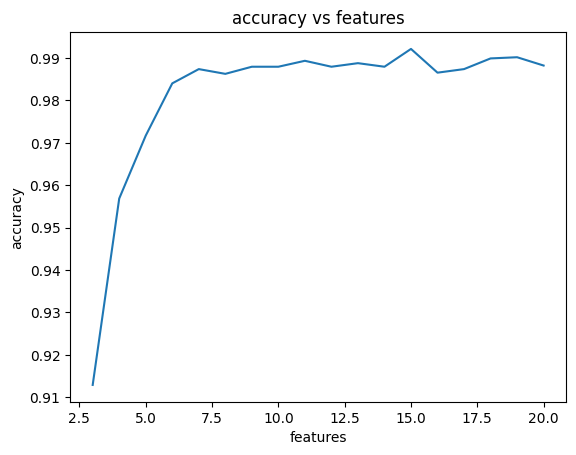

In [6]:
accuracys = []
for i in [1e-1]:
    for j in range(3,21):
        mahalanobis_layer = MahalanobisLayer(alpha=i)
        mahalanobis_layer.fit(X_train, y_train)

        grid_classifier = GridGraphClassifier(n_bins=j)
        grid_classifier.fit(X_valid, y_valid, mahalanobis_layer)

        results = grid_classifier.predict(X_test, mahalanobis_layer)
        accuracys.append(accuracy_score(y_test,results))
print(accuracy_score(y_test,results))
print("\nClassification Report:\n", classification_report(y_test, results))
cm = confusion_matrix(y_test, results)

# Confusion Matrix Plot
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()
features = list(range(3,21))
print(accuracys)
plt.plot(features, accuracys)
plt.title("accuracy vs features")
plt.xlabel("features")
plt.ylabel('accuracy')

plt.show()

In [7]:
print(accuracys)

[0.9129095491458975, 0.9568748249789975, 0.9717166059927191, 0.9840380845701484, 0.9873984878185382, 0.9862783534024083, 0.9879585550266032, 0.9879585550266032, 0.9893587230467656, 0.9879585550266032, 0.9887986558387006, 0.9879585550266032, 0.9921590590870905, 0.9865583870064407, 0.9873984878185382, 0.9899187902548305, 0.990198823858863, 0.9882385886306356]


In [58]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# Train the model
rf_model.fit(X_valid, y_valid)

# Predictions
y_pred = rf_model.predict(X_test)

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")


print("\nClassification Report:\n", classification_report(y_test, y_pred))


print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.8730

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.94      0.95       400
           1       0.89      0.83      0.86       400
           2       0.98      0.96      0.97       400
           3       0.98      0.96      0.97       400
           4       0.80      0.89      0.84       400
           5       0.88      0.68      0.76       400
           6       0.57      0.88      0.69       400
           7       0.93      0.96      0.95       400
           8       0.88      0.57      0.69       400
           9       0.98      0.97      0.97       400
          10       0.92      0.96      0.94       400

    accuracy                           0.87      4400
   macro avg       0.89      0.87      0.87      4400
weighted avg       0.89      0.87      0.87      4400


Confusion Matrix:
 [[374   2   0   0   8   1   1   7   1   1   5]
 [  1 334   0   0  63   0   0   0   0   0   2]
 [  0   0 385   0   3   6   1  

In [13]:
class MahalanobisLayer:
    def __init__(self, alpha=1e-5):
        self.centroids = None
        self.covariance_inv = None
        self.class_labels = None
        self.alpha = alpha  # Regularization for covariance stability

    def fit(self, X_train, y_train):
        self.class_labels = np.unique(y_train)
        self.centroids = []
        self.covariance_inv = []
        for label in self.class_labels:
            class_data = X_train[y_train == label]
            centroid = np.mean(class_data, axis=0)
            cov = np.cov(class_data.T) + np.eye(class_data.shape[1]) * self.alpha
            self.centroids.append(centroid)
            self.covariance_inv.append(np.linalg.inv(cov))
        return self
    def predict(self, X):
        n_classes = len(self.centroids)
        predictions = []
        for x in X:
            distances = np.zeros(n_classes)
            for j in range(n_classes): 
                    distances[j] = mahalanobis(x, self.centroids[j], self.covariance_inv[j])
            distances = np.where(np.isnan(distances), float('inf'), distances)
            predictions.append(distances)
        return np.array(predictions)
class MultiLayerMahalanobis:
    def __init__(self, n_layers=2, alpha=1e-5, n_neighbors=1):
        self.layers = [MahalanobisLayer(alpha) for _ in range(n_layers)]
        #self.preprocessor = DataPreprocessor()
        self.n_layers = n_layers
        self.n_neighbors = n_neighbors
        self.X_train_features = None
        self.y_train = None
        self.class_labels = None

    def gelu(self, x):
        return 0.5 * x * (1 + np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * x**3)))

    def fit(self, X_current, y_train):
        #X_current = self.preprocessor.preprocess(X_train, fit_scalers=True)
        for i, layer in enumerate(self.layers):
            layer.fit(X_current, y_train)
            X_current = layer.predict(X_current)
            if i < self.n_layers - 1:
                X_current = self.gelu(X_current)
        self.X_train_features = X_current
        self.y_train = y_train
        self.class_labels = np.unique(y_train)
        return self

    def predict(self, X_current):
        for i, layer in enumerate(self.layers):
            X_current = layer.predict(X_current)
            # if i < self.n_layers - 1:
            #     X_current = self.gelu(X_current)
        X_test_features = X_current

        # Relational classification using wvRN
        nn = NearestNeighbors(n_neighbors=self.n_neighbors, metric='cosine')
        nn.fit(self.X_train_features)
        distances, indices = nn.kneighbors(X_test_features)
        weights = 1 / (distances + 1e-8)

        y_pred = []
        for i in range(len(X_test_features)):
            neighbor_labels = self.y_train.iloc[indices[i]]
            neighbor_weights = weights[i]
            class_weights = {c: np.sum(neighbor_weights[neighbor_labels == c]) 
                             for c in self.class_labels}
            total_weight = np.sum(neighbor_weights)
            predicted_class = max(class_weights, key=lambda c: class_weights[c] / total_weight if total_weight > 0 else 0)
            y_pred.append(predicted_class)
        return np.array(y_pred)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import kneighbors_graph
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, BatchNorm
from tqdm import tqdm

# Assume x_train, y_train are numpy arrays
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)

x_train_tensor = torch.tensor(x_train_scaled, dtype=torch.float)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

adj_train = kneighbors_graph(x_train_scaled, n_neighbors=6, include_self=True)
row, col = adj_train.nonzero()
edge_index_train = torch.tensor([row, col], dtype=torch.long)

train_data = Data(x=x_train_tensor, edge_index=edge_index_train, y=y_train_tensor)

class GNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.bn1 = BatchNorm(hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.bn2 = BatchNorm(hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)
        self.dropout = nn.Dropout(0.4)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.bn1(self.conv1(x, edge_index)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.conv2(x, edge_index)))
        x = self.dropout(x)
        return self.conv3(x, edge_index)

model = GNN(x_train_tensor.shape[1], 64, len(set(y_train)))
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

for epoch in tqdm(range(1, 501)):
    model.train()
    optimizer.zero_grad()
    out = model(train_data)
    loss = loss_fn(out, y_train_tensor)
    loss.backward()
    optimizer.step()

    if epoch % 50 == 0:
        pred = out.argmax(dim=1)
        acc = (pred == y_train_tensor).sum().item() / len(y_train)
        print(f"Epoch {epoch:03d}, Loss: {loss.item():.4f}, Train Acc: {acc:.4f}")
